<h1>Home Advantage</h1>
<h2>Introduction</h2>

Recently I was fortunate enough to attend two matches at Boca Juniors' infamous Bombanera Stadium. The first being a rather forgettable (at least football-wise) 2-1 loss against bottom of the league Colón. The second was a more convincing 1-0 victory against Huracán.

In truth the real attraction to Argentian football, or South American football in general, is the atmosphere. The fans never stop chanting, singing and dancing regardless of what is occurring on the pitch. A far cry from English football where the crowd mood is entirely dictated by the flow of the game.

I was so taken by the atmosphere of the first game I attended, I didn't realise something was missing - away fans. This is because in 2013 the Argentinian FA chose to outlaw away fans after a spate of football-related violence. Home advantage is a well-documented phenomenon in football, this was reaffirmed during the COVID seasons in which results were more agnostic of stadia than in a normal season. 

This got me to thinking; How much has this change in regulation changed home advantage in Argentina? 




<h2> Data Preparation </h2>

The data for this exercise have been retrieved from www.football-data.co.uk, a great resource for historic match results and betting odds (crucial for estimating probabilities). Unfortunately the Argentinian league only has data back to 2012 which gives us only one year for a pre-away fan sample.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson,skellam
pd.options.mode.chained_assignment = None

In [3]:
# Import data and select relevant columns
arg_league_data = pd.read_csv("data/arg_fb_data.csv")
arg_league_cropped = arg_league_data[['League','Season','Home','Away','HG','AG']]

# Strip trailing space pre 2017/18 from league
arg_league_cropped.League = arg_league_cropped['League'].str.strip()
arg_league_cropped = arg_league_cropped[arg_league_cropped.League == "Liga Profesional"]


In [7]:
# Split into two data sets pre and post ban
arg_league_cropped = arg_league_cropped[arg_league_cropped.League == "Liga Profesional"]
arg_league_pre = arg_league_cropped[arg_league_cropped.Season == "2012/2013"]
arg_league_post = arg_league_cropped[arg_league_cropped.Season.isin(["2013/2014", "2014/2015"])]#, "2020/2021", "2021/2022"])]


In [8]:
arg_league_pre.mean()

HG    1.293963
AG    0.947507
dtype: float64

In [9]:
arg_league_post.mean()

HG    1.271540
AG    0.848564
dtype: float64

We can see in both time periods, the number of home goals exceeds the number of away goals. This passes the initial assumption that home advantage exists to some degree. However, the average goals scored for away teams appears to increase after the ban on away fans. Similarly, the number of goals scored by the home team decreases. This will be examined in more detail later.

<h2> Poisson Distribution </h2>

We can use a poisson distribution to calculate the expected number of goals for both the home and away team in <i>any given match in this league</i>. This is not in itself a particularly useful statistic for estimating scores of isolated matches as it negates the difference in quality of each team. Rather this can be used to assess the overall affect of home advantage

In [10]:
# Create home goal proportion
hg_prop = arg_league_post.groupby("HG").count()
hg_prop['Home Goal Proportion'] =  hg_prop['League'] / hg_prop['League'].sum()
hg_prop = hg_prop[['Home Goal Proportion']] 
hg_prop

# Repeat for away goal proportion
ag_prop = arg_league_post.groupby("AG").count()
ag_prop['Away Goal Proportion'] =  ag_prop['League'] / ag_prop['League'].sum()
ag_prop = ag_prop[['Away Goal Proportion']] 
ag_prop


,Away Goal Proportion
AG,
0,0.420366
1,0.370757
2,0.154047
3,0.049608
4,0.005222


In [11]:
# Merge the two data sets
merged_prop = hg_prop.join(ag_prop, how='outer')

# Display merged dataframe
merged_prop.fillna(0, inplace=True)

In [12]:
# Convert index to new column called goals
merged_prop = merged_prop.reset_index().rename(columns={'index': 'Goals'})

# Display updated dataframe
merged_prop

,Goals,Home Goal Proportion,Away Goal Proportion
0,0,0.284595,0.420366
1,1,0.347258,0.370757
2,2,0.216710,0.154047
3,3,0.120104,0.049608
4,4,0.026110,0.005222
5,5,0.005222,0.000000


/Users/hallamcunningham/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout(*args, **kwargs)


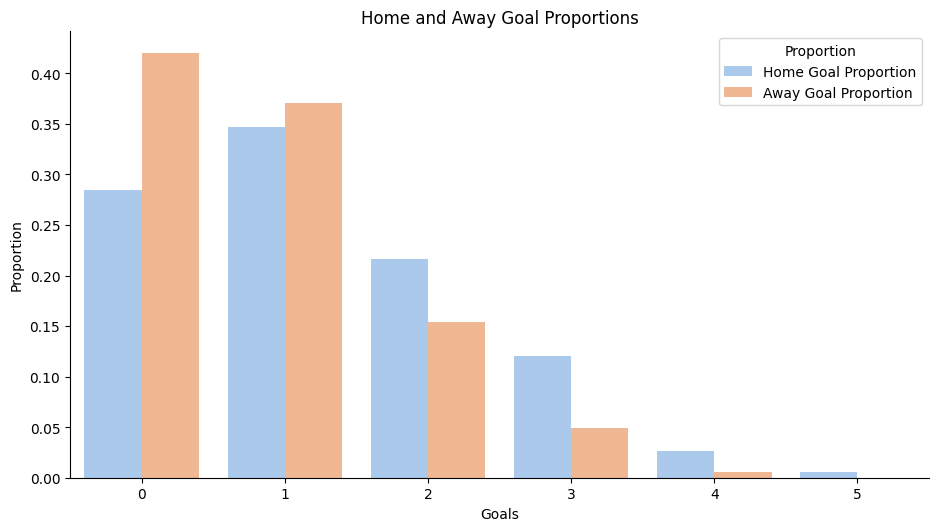

In [13]:

# Create catplot with goals as x-axis and HG Proportion and AG Proportion as y-values
a = sns.catplot(x='Goals',
            y='value',
            hue='variable',
            data=pd.melt(merged_prop, id_vars = 'Goals'),
            kind='bar',
            palette='pastel',
            legend_out=False)
a.fig.set_size_inches(10,5)

# Set chart title and axis labels
plt.title('Home and Away Goal Proportions')
plt.xlabel('Goals')
plt.ylabel('Proportion')

plt.legend(title='Proportion', loc='upper right')


with the actual number of goals scored in each game plotted, we can simulate the expected number of goals scored by fitting a poisson distribution to the data. For reference, the formula for the poisson distribution is as follows:
<img src="assets/poisson.png">
where lambda is the average number of successes (in our case goals) and X is the number of successes we want to predict a probability for

/Users/hallamcunningham/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout(*args, **kwargs)


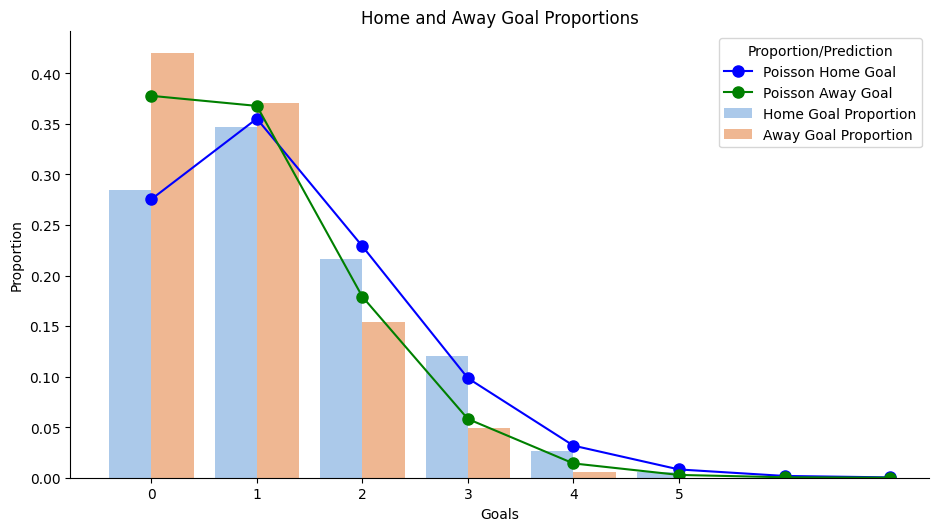

In [14]:

# Create catplot with goals as x-axis and HG Proportion and AG Proportion as y-values
b = sns.catplot(x='Goals',
            y='value',
            hue='variable',
            data=pd.melt(merged_prop, id_vars = 'Goals'),
            kind='bar',
            palette='pastel',
            legend_out=False)
b.fig.set_size_inches(10,5)

# Set chart title and axis labels
plt.title('Home and Away Goal Proportions')
plt.xlabel('Goals')
plt.ylabel('Proportion')


# Set lambda parameter
lam_hg = 1.289557
lam_ag = 0.973629

# Create Poisson distribution
poisson_dist_hg = poisson(lam_hg)
poisson_dist_ag = poisson(lam_ag)

# Plot probability mass function of Poisson distribution
x = np.arange(0, 8)
plt.plot(x, poisson_dist_hg.pmf(x), 'o-', color = 'blue', ms=8, label='Poisson Home Goal')
plt.plot(x, poisson_dist_ag.pmf(x), 'o-', color = 'green', ms=8, label='Poisson Away Goal')

plt.legend(title='Proportion/Prediction', loc='upper right')
# Display chart
plt.show()

Now we have the porportion of actual goals scored by both the home and away teams in the league versus a prediction from their corresponding Poisson probability mass functions. It can be seen that the fit for the home goals is far better than away, but both are fairly accurate.

We can also estimate the probability of a selected number of goals to be scored by each team. For example the probability of the home team scoring 3 goals in any argentinian league game according to the poisson distribution is

In [15]:
three_hg_prob = poisson_dist_hg.pmf(3)
three_hg_prop = merged_prop.iloc[3,1]
print((f"The probability of the home team scoring 3 goals is {round(three_hg_prob*100,2)}% whereas the proportion of goals scored is {round(three_hg_prop*100,2)}%"))

The probability of the home team scoring 3 goals is 9.84% whereas the proportion of goals scored is 12.01%


<h2> The Skellam Distribution </h2>

A skellam distribution gives the probability of the difference of two independent random variables who are poisson distributed. An example would be calculating the goal difference of a home and away teams' goals based on the probability of the home team scoring not affecting the probability of the away team scoring).

In [16]:
pre_draw_chance = skellam.pmf(0,arg_league_pre.mean()[0],arg_league_pre.mean()[1])
post_draw_chance = skellam.pmf(0,arg_league_post.mean()[0],arg_league_post.mean()[1])
print((f"The probability of a draw in the season pre-ban was {round(pre_draw_chance*100,2)}% whereas the probability of a draw post-ban is {round(post_draw_chance*100,2)}%"))


The probability of a draw in the season pre-ban was 28.25% whereas the probability of a draw post-ban is 28.89%


In [17]:
skellam_pred_pre = [skellam.pmf(i,  arg_league_pre.mean()[0],  arg_league_pre.mean()[1]) for i in range(-6,8)]
skellam_pred_post = [skellam.pmf(i,  arg_league_post.mean()[0],  arg_league_post.mean()[1]) for i in range(-6,8)]

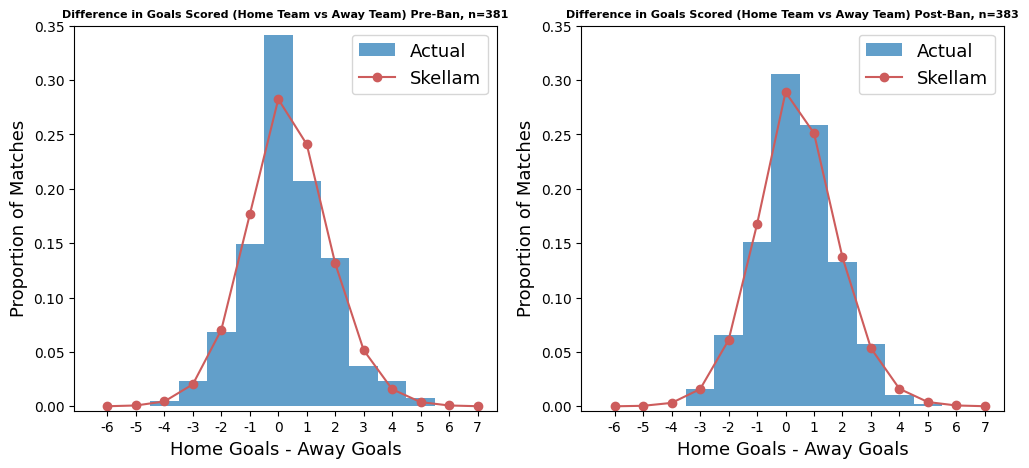

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(arg_league_pre[['HG']].values - arg_league_pre[['AG']].values, range(-6,8), 
         alpha=0.7, label='Actual', density = True)
axs[0].plot([i+0.5 for i in range(-6,8)], skellam_pred_pre,
                  linestyle='-', marker='o',label="Skellam", color = '#CD5C5C')
axs[0].legend(loc='upper right', fontsize=13)
axs[0].set_xticks([i+0.5 for i in range(-6,8)])
axs[0].set_xticklabels([i for i in range(-6,8)])
axs[0].set_xlabel("Home Goals - Away Goals",size=13)
axs[0].set_ylabel("Proportion of Matches",size=13)
axs[0].set_title(f"Difference in Goals Scored (Home Team vs Away Team) Pre-Ban, n={arg_league_pre.Season.count()}",size=8,fontweight='bold')
axs[0].set_ylim([-0.004, 0.35])

axs[1].hist(arg_league_post[['HG']].values - arg_league_post[['AG']].values, range(-6,8), 
         alpha=0.7, label='Actual', density = True)
axs[1].plot([i+0.5 for i in range(-6,8)], skellam_pred_post,
                  linestyle='-', marker='o',label="Skellam", color = '#CD5C5C')
axs[1].legend(loc='upper right', fontsize=13)
axs[1].set_xticks([i+0.5 for i in range(-6,8)])
axs[1].set_xticklabels([i for i in range(-6,8)])
axs[1].set_xlabel("Home Goals - Away Goals",size=13)
axs[1].set_ylabel("Proportion of Matches",size=13)
axs[1].set_title(f"Difference in Goals Scored (Home Team vs Away Team) Post-Ban, n={arg_league_post.Season.count()}",size=8,fontweight='bold')
axs[1].set_ylim([-0.004, 0.35])

plt.show()

using this data we can build a poisson regression model to predict the scores of each game in the league

In [19]:
# importing the tools required for the Poisson regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [20]:
goal_model_data_pre = pd.concat([arg_league_pre[['Home','Away','HG']].assign(home=1).rename(
            columns={'Home':'team', 'Away':'opponent','HG':'goals'}),
           arg_league_pre[['Away','Home','AG']].assign(home=0).rename(
            columns={'Away':'team', 'Home':'opponent','AG':'goals'})])

goal_model_data_post = pd.concat([arg_league_post[['Home','Away','HG']].assign(home=1).rename(
            columns={'Home':'team', 'Away':'opponent','HG':'goals'}),
           arg_league_post[['Away','Home','AG']].assign(home=0).rename(
            columns={'Away':'team', 'Home':'opponent','AG':'goals'})])

In [21]:
poisson_model = smf.glm(formula="goals ~ home + team + opponent", data = goal_model_data_pre,
                       family = sm.families.Poisson()).fit()
poisson_model_p = smf.glm(formula="goals ~ home + team + opponent", data = goal_model_data_post,
                       family = sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  762
Model:                            GLM   Df Residuals:                      722
Model Family:                 Poisson   Df Model:                           39
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1004.7
Date:                Tue, 03 Oct 2023   Deviance:                       822.83
Time:                        11:49:57   Pearson chi2:                     704.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.0989      0.228     -0.434      0.664      -0.545       0.348
team[T.Argentinos Jrs]           -0.0620      0.247     -0.251      0.801      -0.545       0.421
team[T.Arsenal Sarandi]           0.2499      0.229      1.093      0.275      -0.198       0.698
team[T.Atl. Rafaela]              0.1878      0.232      0.808      0.419      -0.268       0.643
team[T.Belgrano]                  0.0268      0.239      0.112      0.911      -0.442       0.496
team[T.Boca Juniors]              0.1091      0.236      0.461      0.645      -0.354       0.572
team[T.Colon Santa FE]            0.3070      0.227      1.355      0.175      -0.137       0.751
team[T.Estudiantes L.P.]         -0.0196      0.243     -0.081      0.936      -0.496       0.456
team[T.Godoy Cruz]                0.0437      0.239      0.183      0.855      -0.426       0.513
team[T.Independiente]            -0.0731      0.247     -0.296      0.767      -0.556       0.410
team[T.Lanus]                     0.3331      0.223      1.491      0.136      -0.105       0.771
team[T.Newells Old Boys]          0.5787      0.213      2.716      0.007       0.161       0.996
team[T.Quilmes]                   0.2511      0.229      1.098      0.272      -0.197       0.699
team[T.Racing Club]               0.3595      0.223      1.615      0.106      -0.077       0.796
team[T.River Plate]               0.4843      0.218      2.224      0.026       0.058       0.911
team[T.San Lorenzo]               0.2845      0.226      1.256      0.209      -0.159       0.728
team[T.San Martin S.J.]           0.4314      0.221      1.953      0.051      -0.002       0.864
team[T.Tigre]                     0.1190      0.236      0.504      0.615      -0.344       0.582
team[T.Union de Santa Fe]        -0.0137      0.245     -0.056      0.955      -0.493       0.466
team[T.Velez Sarsfield]           0.3392      0.223      1.524      0.128      -0.097       0.775
opponent[T.Argentinos Jrs]       -0.0223      0.199     -0.112      0.911      -0.413       0.368
opponent[T.Arsenal Sarandi]      -0.1356      0.206     -0.658      0.510      -0.539       0.268
opponent[T.Atl. Rafaela]          0.0087      0.198      0.044      0.965      -0.380       0.397
opponent[T.Belgrano]             -0.6726      0.241     -2.789      0.005      -1.145      -0.200
opponent[T.Boca Juniors]         -0.0352      0.200     -0.175      0.861      -0.428       0.357
opponent[T.Colon Santa FE]        0.0724      0.196      0.370      0.711      -0.311       0.456
opponent[T.Estudiantes L.P.]     -0.3773      0.220     -1.717      0.086      -0.808       0.053
opponent[T.Godoy Cruz]           -0.2411      0.211     -1.140      0.254      -0.656       0.173
opponent[T.Independiente]        -0.2212     

In [22]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

In [23]:
boca_lan_pre = simulate_match(poisson_model,"Boca Juniors","Lanus",max_goals=10)
# boca win
np.sum(np.tril(boca_lan_pre,-1))

0.2008201694752321

In [24]:
# draw
np.sum(np.diag(boca_lan_pre))

0.302453601890404

In [25]:
# lanus win
np.sum(np.triu(boca_lan_pre,1))

0.49672615501240935

In [26]:
# sense check - boca had a bad season!
arg_league_pre.loc[(arg_league_pre["Home"] == "Lanus") & (arg_league_pre["Away"] == "Boca Juniors")]

,League,Season,Home,Away,HG,AG
78,Liga Profesional,2012/2013,Lanus,Boca Juniors,2,0


if we want to generalise the impact of how much more likely a home team is to score now compared to when away fans were allowed we simply need to subtract the home coefficients away from one another and raise against the natural exponent

In [27]:
print(f"Prior to away fans being banned, the home team were {round(np.exp(poisson_model.params.home),2)} times more likely to score than the away team. Post-ban this changes to {round(np.exp(poisson_model_p.params.home),2)}")



Prior to away fans being banned, the home team were 1.37 times more likely to score than the away team. Post-ban this changes to 1.5


This would suggest that the home advantage did indeed expand in the two seasons following the banning of away fans